# Results


## Introduction

In this notebook, we will present the results of our experiments with six different machine learning models: LSTM, Naive Bayes (NB), RNN, Random Forest (RF), and CNN. We will compare their performance using various metrics, including accuracy, ROC-AUC, F1-score, precision, and recall.
We will also delve into the specific behavior of models in the context of labels and different data splits. At the end, we will try to draw some overall conclusions from these results and analysis.


In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import results as res

## Overview of model performance

We tuned the hyperparameters of each model using nested loops and ran multiple experiments to evaluate their performance. Now, we extract the best model for each algorithm by finding the weighted average of accuracy and ROC-AUC scores on the devtest_rw dataset.

In [2]:
models = ['svm', 'naive_bayes', 'lstm', 'rnn']

for model in models:
    with open(f'../{model}/{model}_results.json', 'r') as f:
        results = json.load(f)
        best_result = res.find_best_result(results)
        with open(f'../{model}/{model}_best_result.json', 'w') as f:
            json.dump(best_result, f, indent=4)

With the best results extracted, we can now compare the performance of the models using the following metrics:
1. Accuracy
2. ROC-AUC

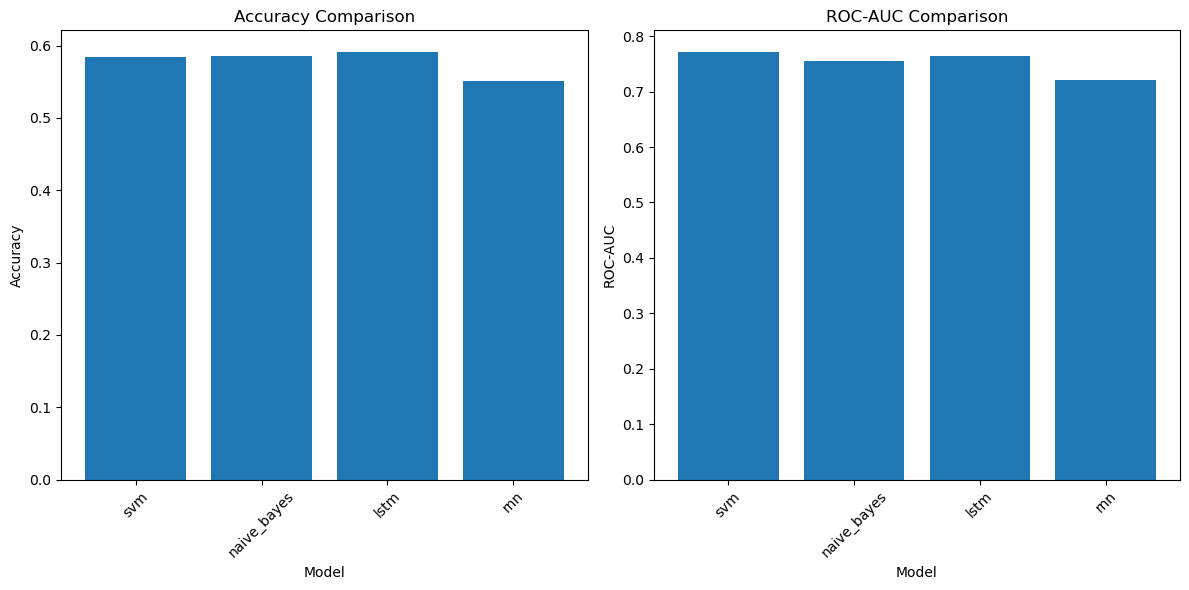

In [3]:
accuracies = {}
roc_aucs = {}
for model in models:
    with open(f'../{model}/{model}_best_result.json', 'r') as f:
        results = json.load(f)
        accuracy, roc_auc = res.get_devtest_rw_full_metrics(results)
        accuracies[model] = accuracy
        roc_aucs[model] = roc_auc

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(models, accuracies.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(models, roc_aucs.values())
plt.xlabel('Model')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
    

Looks like RF and LSTM are performing the best in terms of accuracy and ROC-AUC, although not by very much. All models are pretty close in their overall performance, with RNN performing the worst. Model performance across both metrics is also pretty consistent.

## Overall label-specific performance

We will now analyze the performance of the models on each label. We will use the following metrics:

1. Precision
2. Recall
3. F1-score

### Performance across all models

First, let's look at how all the models performed one each label to get an overall idea of which label is the most difficult to predict.

We get the label metrics for each model and then calculate the average of these metrics across all models.

In [4]:
label_specific_metrics = {}
for model in models:
    with open(f'../{model}/{model}_best_result.json', 'r') as f:
        best_result = json.load(f)
        label_specific_metrics[model] = res.get_label_specific_metrics(best_result)

In [5]:
average_metrics = {}
for metric in ['f1-score', 'recall', 'precision']:
    average_metrics[metric] = {}
    for label in ['0', '1', '2']:
        metric_values = [label_specific_metrics[model][label][metric] for model in models]
        average_metrics[metric][label] = sum(metric_values) / len(metric_values)

Then we plot histograms to visualize the distribution of these metrics across all labels.

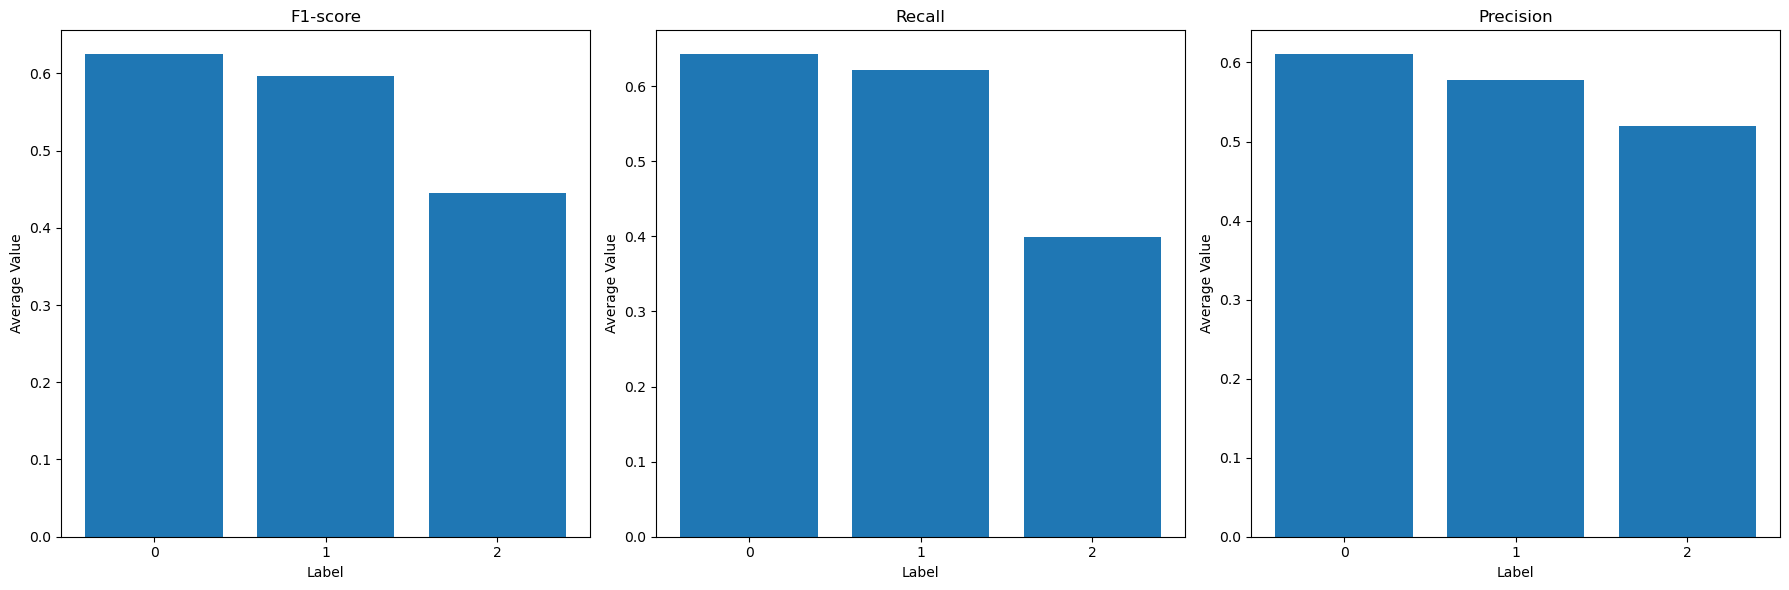

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

labels = ['0', '1', '2']
for i, metric in enumerate(['f1-score', 'recall', 'precision']):
    ax = axs[i]
    ax.bar(labels, [average_metrics[metric][label] for label in labels])
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Label')
    ax.set_ylabel('Average Value')

plt.tight_layout()
plt.show()

Okay, clearly label 2 is the most difficult to predict, with the lowest precision, recall, and F1-score across all models. Label 0 and 1 are seemingly close in terms of difficulty, with label 0 being slightly easier to predict. This means models can tell more accuractely if a review is negative or neutral than if it is positive.

The recall for label 2 is particularly low, which means that the models are not able to correctly identify many of the reviews that are actually positive. This is a problem because it means that the models are not able to capture the positive sentiment in the reviews. We need to see if we can improve this in the future. Maybe use features that identify positive sentiment with more confidence.

We should also look at label specific performance for each model to see if there are any patterns in the performance of the models across different labels.

### Performance for each model

We are utilizing different plotting techniques to visualize the performance of each model across different labels. We will use the following plots:

### Histograms

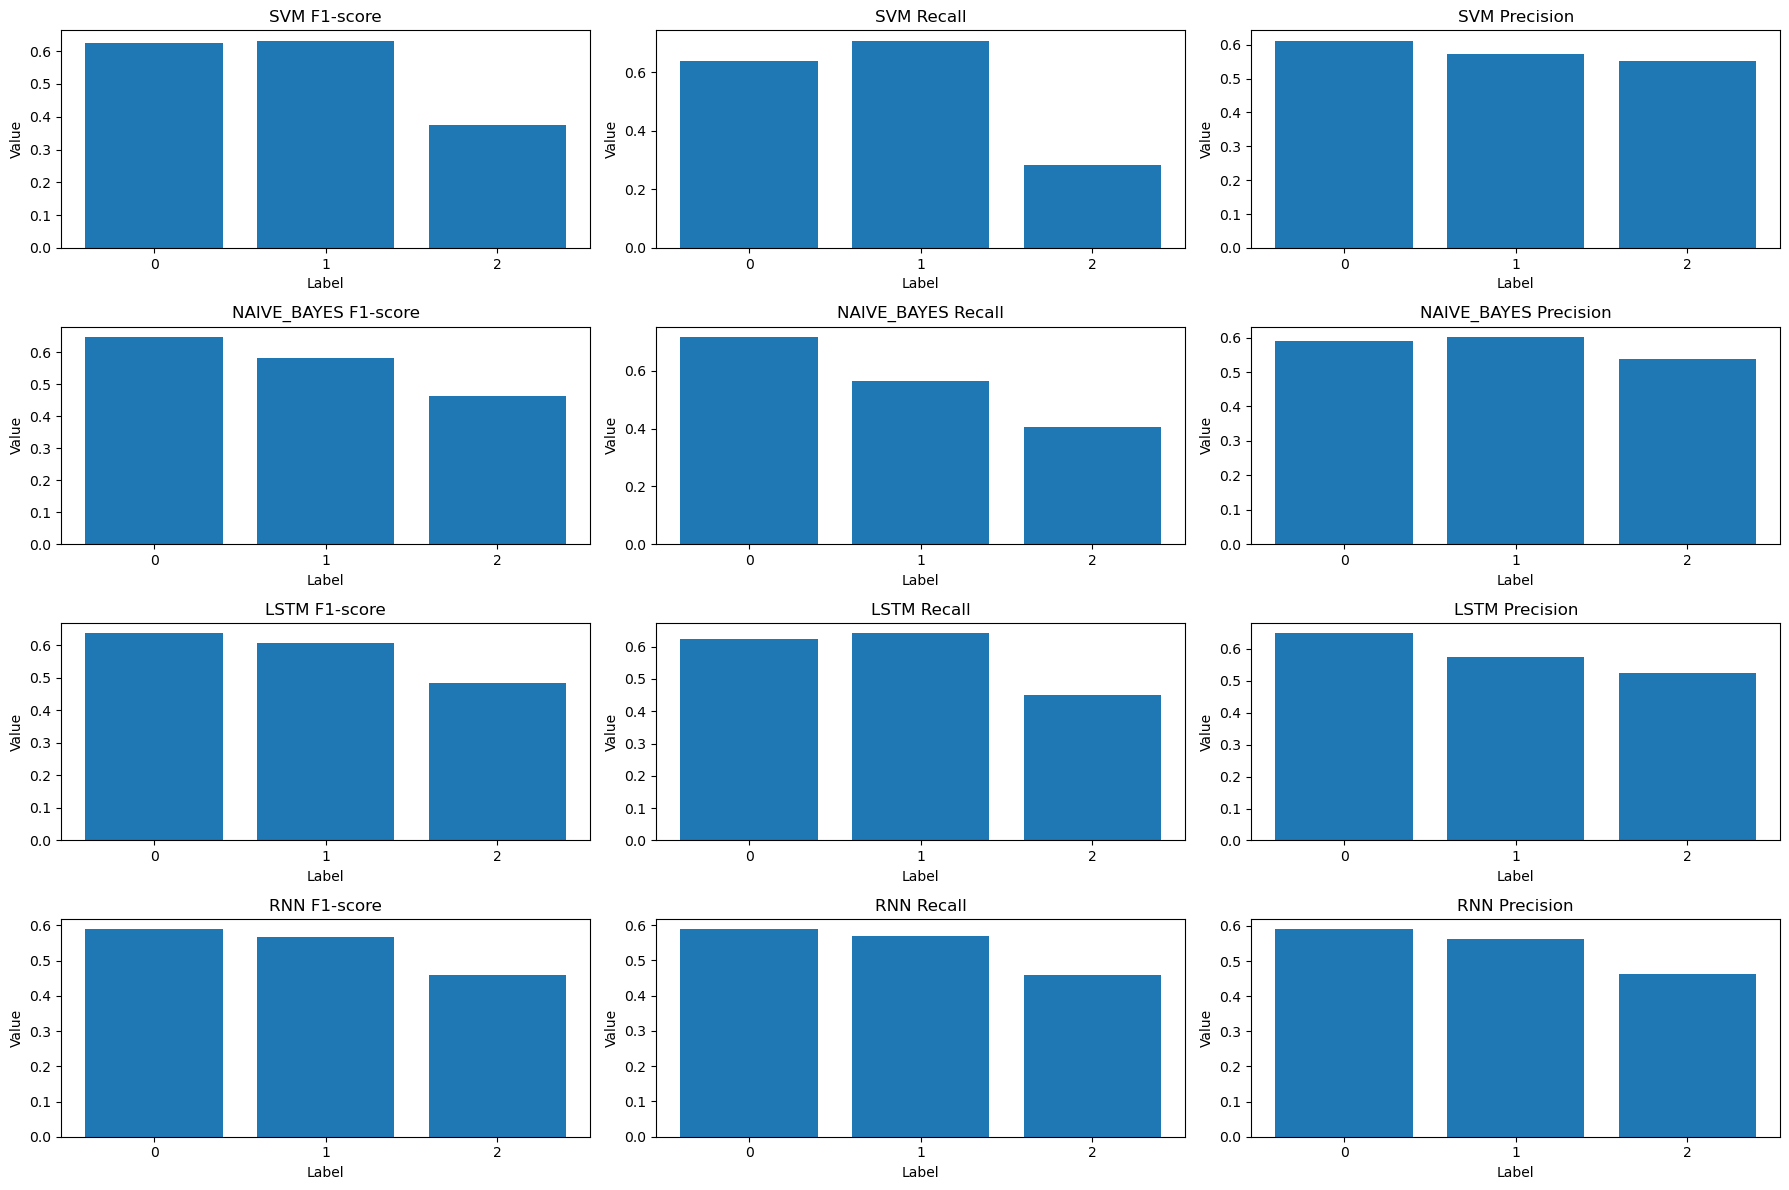

In [7]:
fig, axs = plt.subplots(len(models), 3, figsize=(18, 3*len(models)))

labels = ['0', '1', '2']
for i, model in enumerate(models):
    for j, metric in enumerate(['f1-score', 'recall', 'precision']):
        ax = axs[i, j]
        ax.bar(labels, [label_specific_metrics[model][label][metric] for label in labels])
        ax.set_title(f'{model.upper()} {metric.capitalize()}')
        ax.set_xlabel('Label')
        ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

### Combined histograms

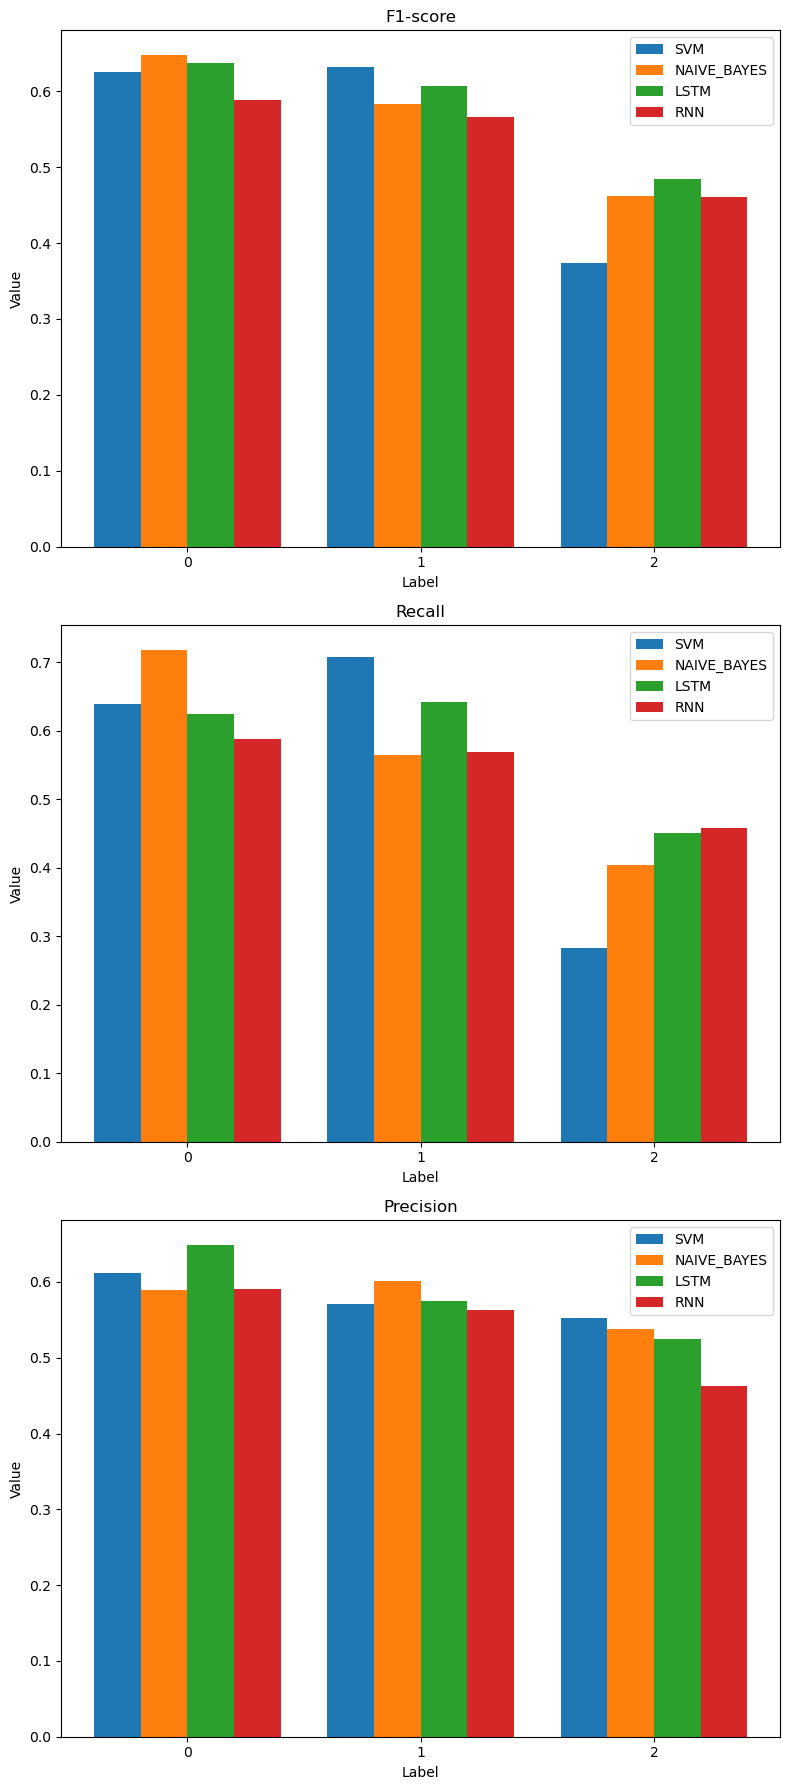

In [8]:
#Giving issues
labels = ['0', '1', '2']
metrics = ['f1-score', 'recall', 'precision']
models = list(label_specific_metrics.keys())

x = np.arange(len(labels))
width = 0.2

fig, axs = plt.subplots(3, 1, figsize=(8, 18))

for i, metric in enumerate(metrics):
    ax = axs[i]
    for j, model in enumerate(models):
        values = [label_specific_metrics[model][label][metric] for label in labels]
        ax.bar(x + j * width, values, width, label=model.upper())
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Label')
    ax.set_ylabel('Value')
    ax.set_xticks(x + (len(models) - 1) * width / 2)
    ax.set_xticklabels(labels)
    ax.legend()

plt.tight_layout()
plt.show()

### Heatmaps

Note: you may need to restart the kernel to use updated packages.


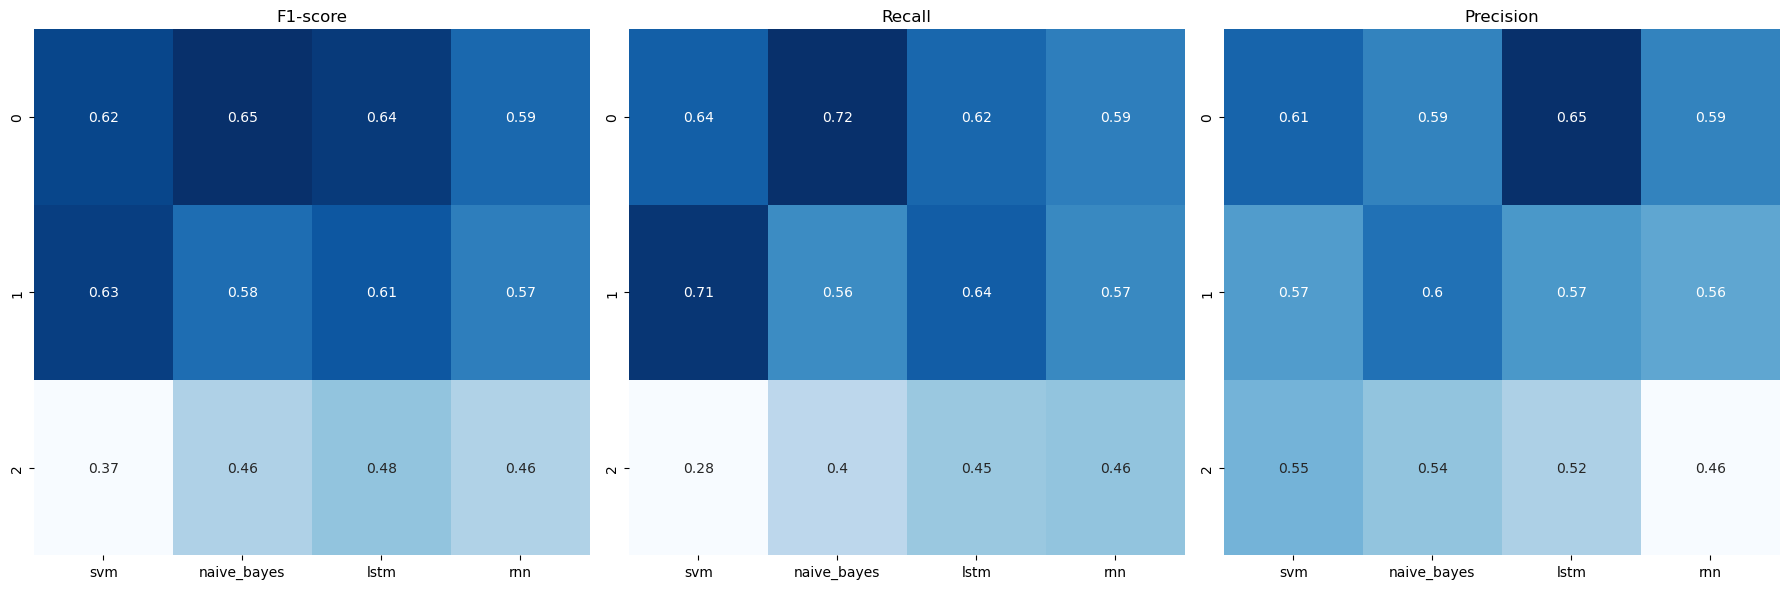

In [10]:
%pip install seaborn
import seaborn as sns
metrics = ['f1-score', 'recall', 'precision']
labels = ['0', '1', '2']
models = list(label_specific_metrics.keys())

data = np.zeros((len(metrics), len(labels), len(models)))

for i, metric in enumerate(metrics):
    for j, label in enumerate(labels):
        for k, model in enumerate(models):
            data[i, j, k] = label_specific_metrics[model][label][metric]

fig, axs = plt.subplots(1, len(metrics), figsize=(18, 6))

for i, metric in enumerate(metrics):
    ax = axs[i]
    sns.heatmap(data[i, :, :], ax=ax, cmap='Blues', annot=True, 
                  xticklabels=models, yticklabels=labels, cbar=False)
    ax.set_title(metric.capitalize())

plt.tight_layout()
plt.show()

### Line plots

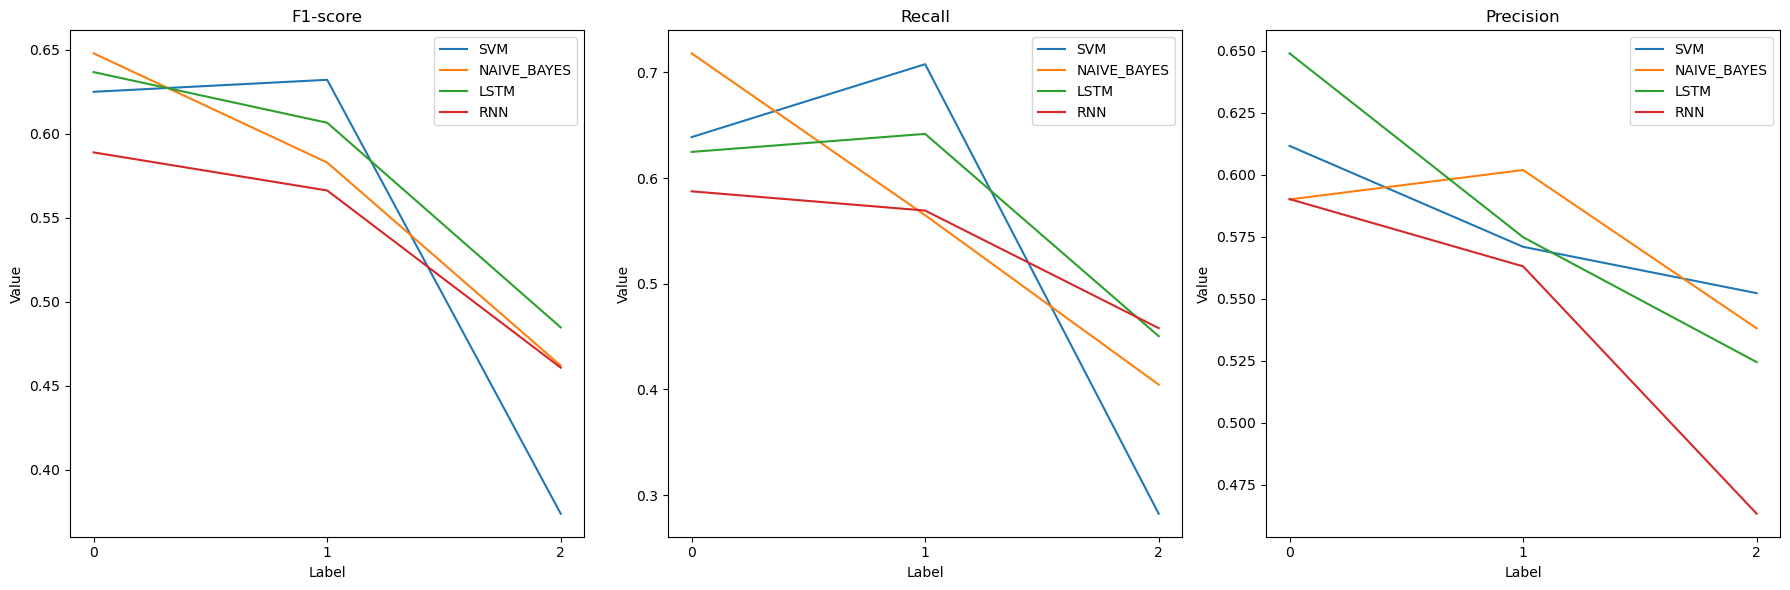

In [11]:
metrics = ['f1-score', 'recall', 'precision']
labels = ['0', '1', '2']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    ax = axs[i]
    for model in models:
        values = [label_specific_metrics[model][label][metric] for label in labels]
        ax.plot(labels, values, label=model.upper())
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Label')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

# Scatter plot

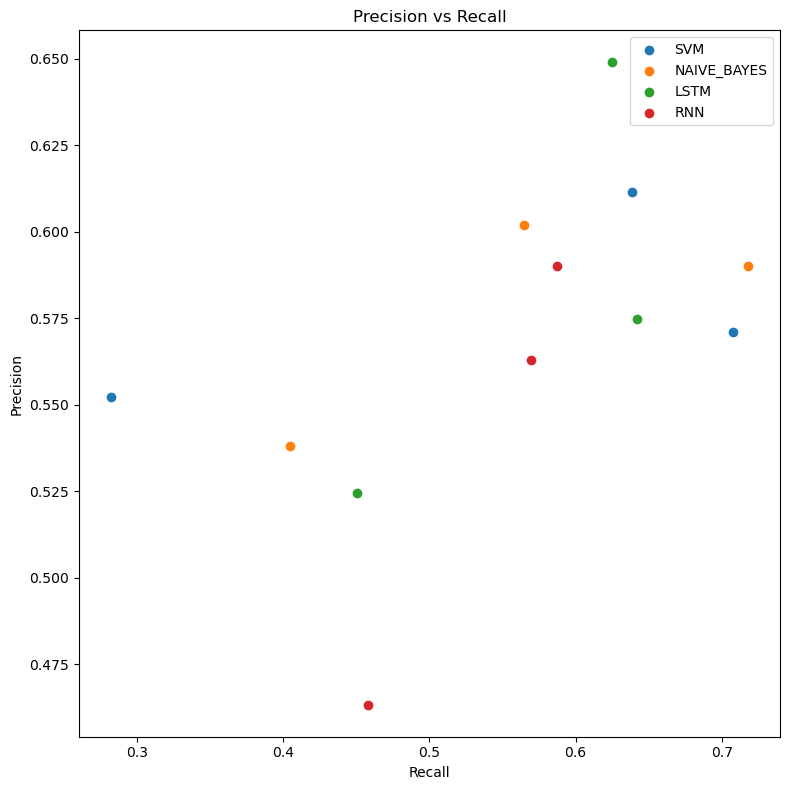

In [12]:
metrics = ['recall', 'precision']
labels = ['0', '1', '2']

fig, axs = plt.subplots(1, 1, figsize=(8, 8))

for model in models:
    recall_values = [label_specific_metrics[model][label]['recall'] for label in labels]
    precision_values = [label_specific_metrics[model][label]['precision'] for label in labels]
    axs.scatter(recall_values, precision_values, label=model.upper())

axs.set_title('Precision vs Recall')
axs.set_xlabel('Recall')
axs.set_ylabel('Precision')
axs.legend()

plt.tight_layout()
plt.show()

# Box plots

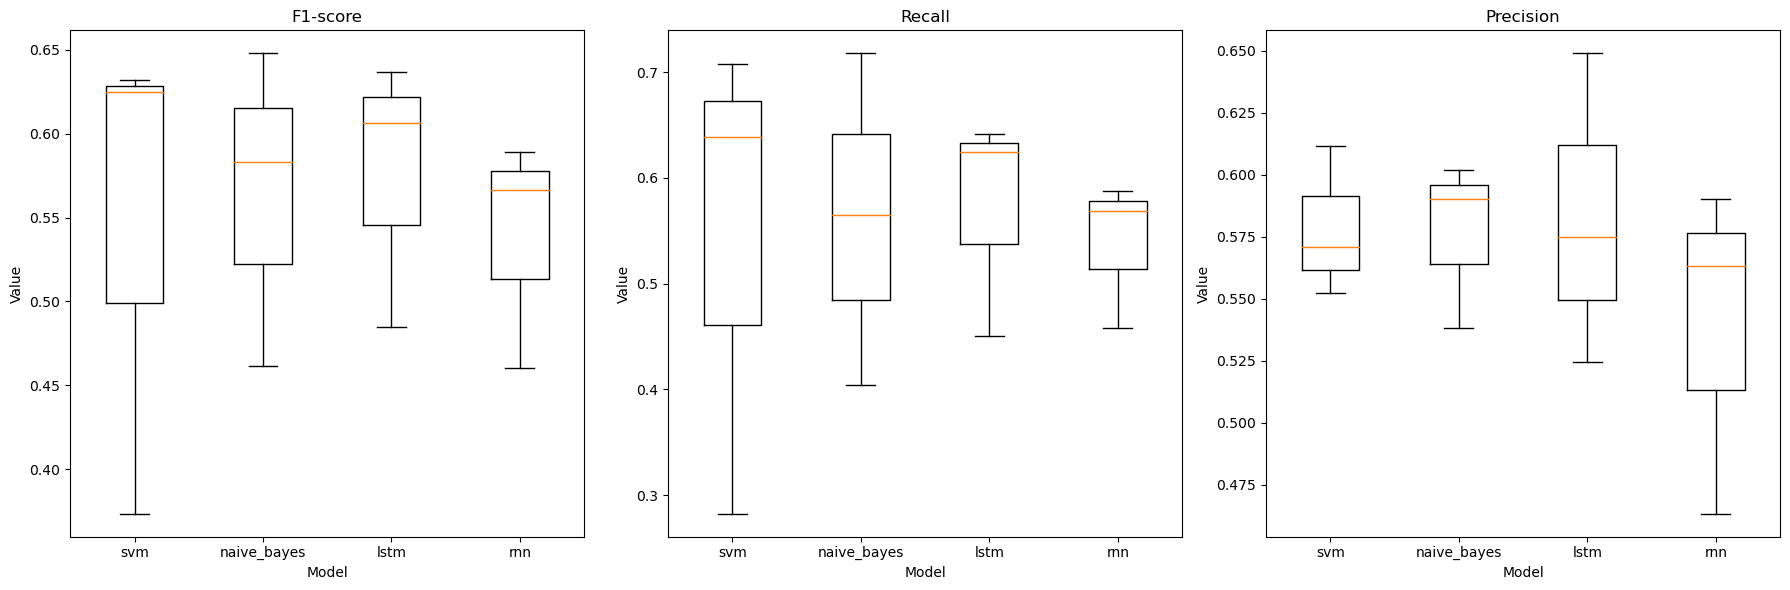

In [13]:
metrics = ['f1-score', 'recall', 'precision']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    ax = axs[i]
    values = [[label_specific_metrics[model][label][metric] for label in ['0', '1', '2']] for model in models]
    ax.boxplot(values, labels=models)
    ax.set_title(metric.capitalize())
    ax.set_xlabel('Model')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()